# Исследование объявлений о продаже квартир

В нашем распоряжении архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Интрументарий 

In [4]:
#работа с базой
import pandas as pd
import numpy as np
#написание функций
import random
#визуализация
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

## Общая информация о файле. 

In [7]:
# Прочитаем файл csv
data = pd.read_csv('~/apartments-for-sale/real_estate_data.csv', sep='\t', decimal='.')
# Снимем ограничения по отображению
pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [8]:
# Увидем таблицу воочию
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


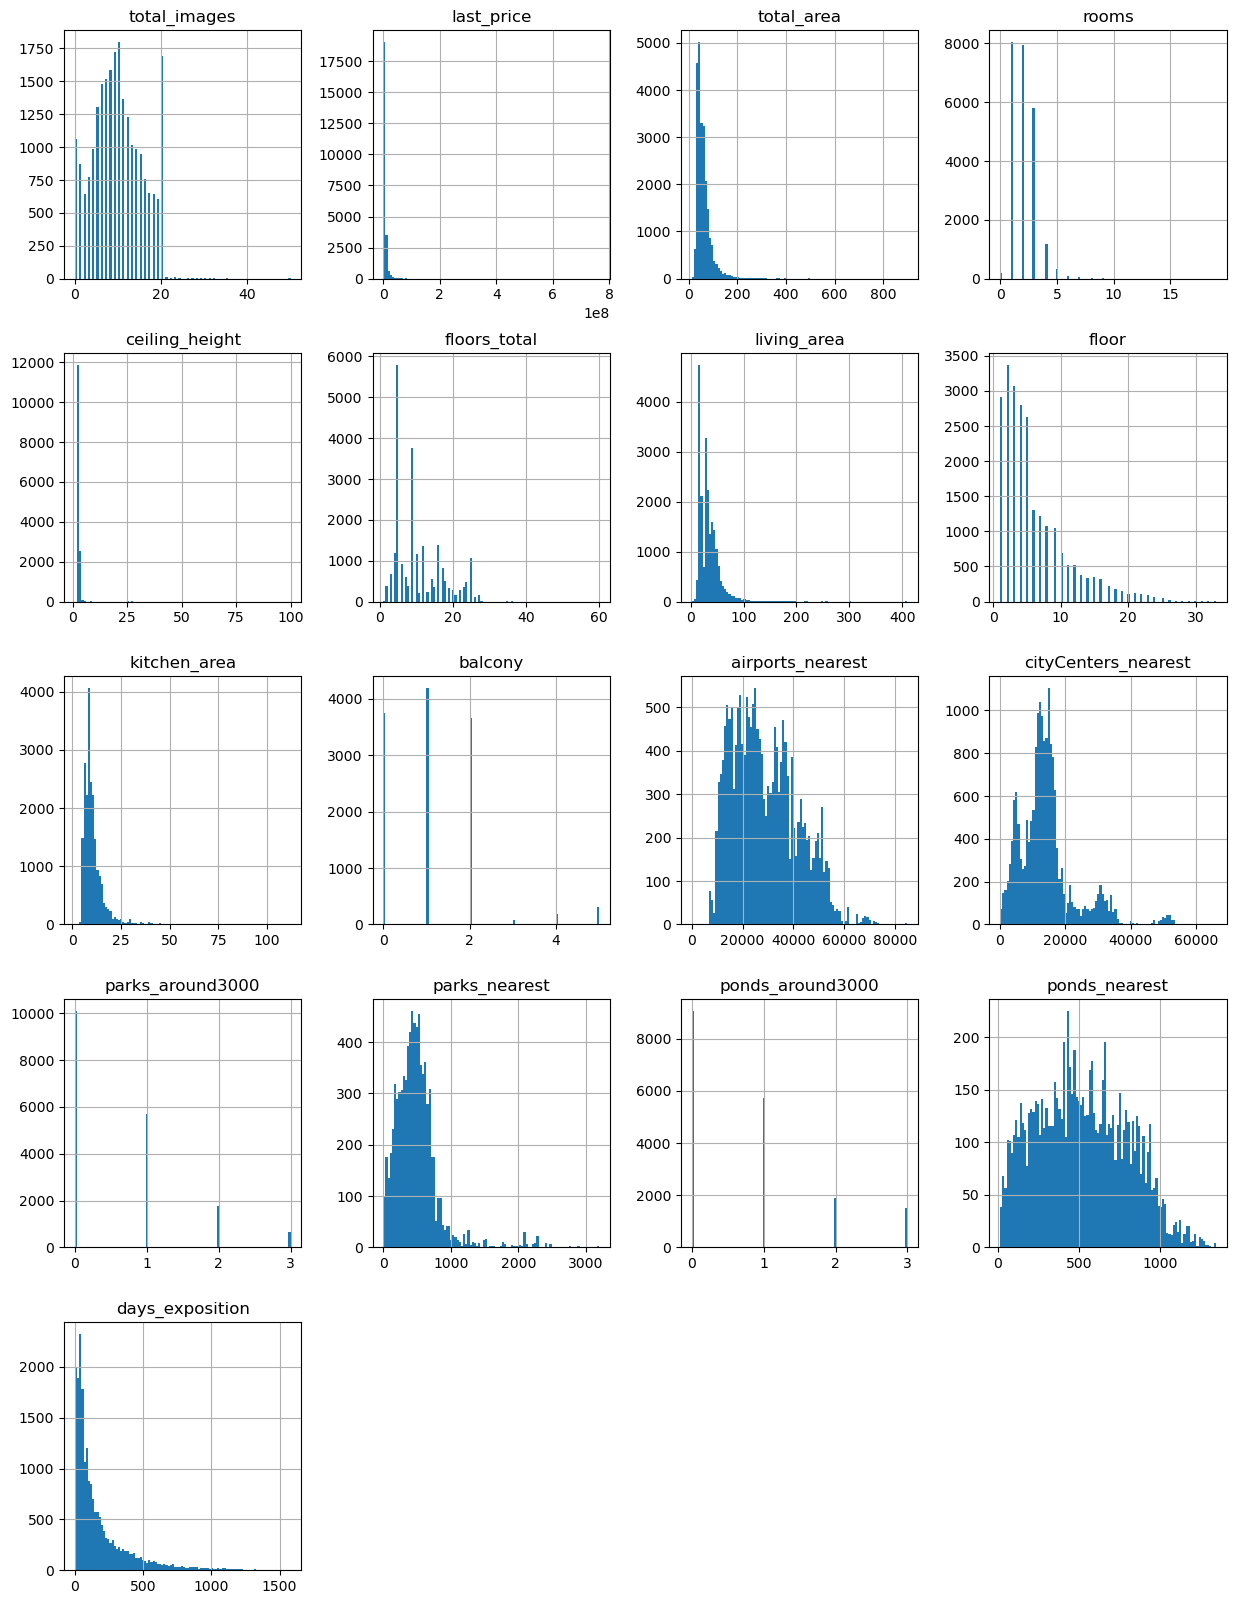

In [9]:
data.hist(figsize=(15, 20), bins=100)
plt.show()

Исходя из предварительной оценки графиков возникли следующие гипотезы:
1. Наибольшее предложение имеется среди малогабаритных квартир 1-2 комнаты.
2. В данных имеются аномалии, например, всплески на графике количества этажей. Это может быть связано с типовой застройкой зданиями 5 и 9 этажей.
3. Продать чаще всего пытаются квартиры на нижних этажах.
4. Большинство предложений закрываются за первые 250 дней публикации.

## Предобработка данных

In [11]:
# Определим список столбцов с пропусками
# Словарь с данными о пропусках
empty_in_columns = {'columns':[],'empty':[], 'percent':[]}
# Цикл заполнения словаря
for i in data.columns.to_list():
    if data[i].isna().sum() != 0:
        empty_in_columns['columns'].append(i)
        empty_in_columns['empty'].append(data[i].isna().sum())
        empty_in_columns['percent'].append(data[i].isna().sum() / data.shape[0])
# Создаём датафрейм с данными о пропусках    
empty_in_columns_df = pd.DataFrame(empty_in_columns, index=empty_in_columns['columns'], columns=['empty', 'percent'])
empty_percent = pd.DataFrame(data.isna().mean()*100)
empty_percent.columns = ['empty_percent']
empty_percent.sort_values('empty_percent', ascending=False).style.background_gradient('coolwarm')

,empty_percent
is_apartment,88.290645
parks_nearest,65.909954
ponds_nearest,61.559559
balcony,48.605426
ceiling_height,38.799105
airports_nearest,23.384953
cityCenters_nearest,23.287902
ponds_around3000,23.283683
parks_around3000,23.283683
days_exposition,13.422507


Наибольшая концентрация пропусков, более 50%, обнаружена в столбцах is_apartment, parks_nearest, ponds_nearest.
По заполнению пропущенных значений предлягается следующее:
- is_apartment - скорее всего не заполнен пользователем, владельцы апартаментов могут намеренно не заполнять информацию, предлагаю заполинть пустые ячейки в том же процентном соотношении, что и заполненные. Распределить случайным образом;
- parks_nearest - возможен сбой в выгрузке, можно заменить медианным значением по населенному пункту;
- ponds_nearest - возможен сбой в выгрузке, можно заменить медианным значением по населенному пункту;
- balcony - не заполнен пользователем, отсутствие данных можно считать отсутствием балкона;
- ceiling_height - скорее всего не заполнена пользователем, можно взять медиану среди зданий эквивалентной этажности;
- airports_nearest - технический сбой, можно заменить медианным значением по населенному пункту либо исключить;
- cityCenters_nearest	- технический сбой, можно заменить медианным значением по населенному пункту либо исключить;
- parks_around3000 - технический сбой, можно заменить медианным значением по населенному пункту либо исключить;
- ponds_around3000 - технический сбой, можно заменить медианным значением по населенному пункту либо исключить;
- days_exposition	- технический сбой, лучше не менять;
- kitchen_area - скорее всего не заполнена пользователем, можно взять медиану среди зданий эквивалентной этажности и комнатности;
- living_area	- скорее всего не заполнена пользователем, можно взять медиану среди зданий эквивалентной этажности и комнатности;
- floors_total - не заполнен пользователем, процент мал, а качество ключевое, следует сключить из подборки;
- locality_name - не заполнен пользователем, процент мал, а качество ключевое, следует сключить из подборки.

In [12]:
# приведем названия столбцов к змеиному регистру
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest','parks_around3000': 'parks_around',
                            'ponds_around3000': 'ponds_around'})
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around', 'parks_nearest', 'ponds_around', 'ponds_nearest',
       'days_exposition'],
      dtype='object')

In [13]:
# Определим количество уникальных значений для апартаментов
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

In [14]:
data['is_apartment'].value_counts()[0]

2725

In [15]:
#рассчитаем количество пустых ячеек которые станут True

a = int(np.divide(data.query('is_apartment.isna()').shape[0], \
(data['is_apartment'].value_counts()[0] \
   / data['is_apartment'].value_counts()[1])))
a

383

Случайным образом заполним отстутствующие данные об апартаментах.

In [16]:
# Выберем случайным образом долю пустых ячеек равную доле апартаментов от заполненных значений

# Собираем индексы пустых ячеек
is_apartment_index_list = data.query('is_apartment.isna()').index.to_list()
# Выбираем из них случайные,
random_index_apartment = random.sample(is_apartment_index_list, a)

In [17]:
# раскидаем апартаменты по случайным индексам в существующей пропорции 2725 к 50
for i in data.index:
    if i in random_index_apartment:
        data.loc[data.index == i, 'is_apartment'] = True

# Оставшиеся отметим как жилые помешения
data.loc[data['is_apartment'] != True, 'is_apartment'] = False

# Проверим факт заполнения
print(data['is_apartment'].value_counts())

False    23266
True       433
Name: is_apartment, dtype: int64


In [18]:
# установим наличие полных дубликатов
data.duplicated().sum()


0

Проверка на пропуски показала успех.

### Работаем с пропусками количества этажей и площади

In [19]:
# Удалим строки с пропусками floors_total и locality_name
data = data.dropna(subset=['locality_name','floors_total'])

# Проверка удаления строк 
print(data['locality_name'].isna().sum(), data['floors_total'].isna().sum())

0 0


### Работа с пропусками в количестве балконов

Если пропуск - вероятнее всего балкон отсутствует.

In [21]:
# Определим показатели стлобца balcony
print(data['balcony'].isna().sum())
print(data.balcony.value_counts())

11475
1.0    4187
0.0    3680
2.0    3656
5.0     304
4.0     182
3.0      81
Name: balcony, dtype: int64


In [22]:
# Незаполненную информацию о налиции балкона воспримем как ноль
data['balcony'] = data['balcony'].fillna(0)

In [23]:
# Определим показатели стлобца balcony
print(data['balcony'].isna().sum())

0


### Работа с пропусками высоты потолков ceiling_height

In [24]:
# Аналогичным образом поступив с ceiling_height
# Проверим пропуски
data['ceiling_height'].isna().sum()

9084

Для начала определим аномальные значения

<Axes: >

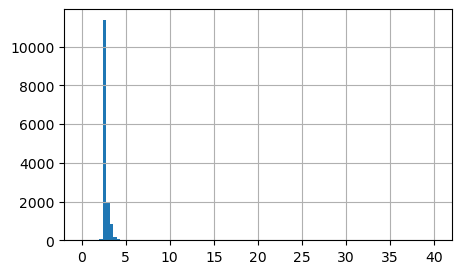

In [26]:
data['ceiling_height'].hist(bins=100, figsize=(5, 3), range=(0, 40))

Много аномальных значений больше 10 метров, устраним самую очевидную ошибку при вводе

In [27]:
# первая категория пропусков характеризована опечаткой, когда в десятичной дроби забывают поставить запятую
data.loc[data['ceiling_height'] >= 18, 'ceiling_height'] = data.loc[data['ceiling_height'] >= 18, 'ceiling_height'] / 10

<Axes: >

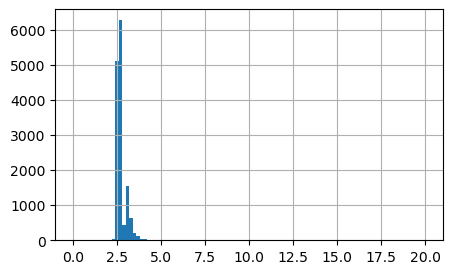

In [29]:
data['ceiling_height'].hist(bins=100, figsize=(5, 3), range=(0, 20))

In [30]:
data['ceiling_height'].value_counts()

2.50     3522
2.60     1646
2.70     1579
3.00     1108
2.80      988
2.55      980
2.75      907
2.65      674
3.20      278
3.10      203
2.90      164
3.30      141
2.56      139
3.50      130
2.57      103
2.85      101
3.40       92
2.54       83
2.64       81
2.52       79
2.53       67
2.58       63
2.77       61
2.76       60
3.15       57
2.78       51
2.95       47
3.05       46
4.00       38
3.25       36
3.60       36
2.67       36
2.73       35
2.51       34
2.72       31
3.70       30
2.74       28
2.40       24
2.68       23
3.80       20
2.84       19
2.82       18
3.55       17
2.66       17
3.35       16
3.12       16
2.83       15
2.45       15
2.59       14
3.90       14
3.08       14
2.62       14
2.63       13
2.71       13
2.88       12
2.00       12
3.13       11
3.18       11
3.07       11
3.06       11
3.33       10
2.87       10
2.79       10
4.20       10
2.92        9
3.45        9
2.81        9
3.38        8
2.48        8
3.95        8
3.02        8
3.75  

Сразу стало адекватнее, но остались аномально высокие потолки, также появились аномально низкие, обработаем

In [31]:
# Очистим их и заполним медианами
data.loc[(data['ceiling_height'] > 8) | (data['ceiling_height'] < 1.8), 'ceiling_height'] = np.nan

In [32]:
data['ceiling_height'].isna().sum()

9091

In [33]:
print(data['ceiling_height'].median(), data['ceiling_height'].max(), data['ceiling_height'].min())

2.65 8.0 2.0


### Заполнение пропусков исходя из похожих объектов

Для дальнейшей работы с пропусками создадим две сводных таблицы, одна соберет медиану исходя из количества этажей и комнат, вторая только комнат в случае, если информации из первой будет недостаточно.

In [34]:
# Создадим сводную таблицу по жилой площади, кухне и высоте потолков, распределение - всего этажей/к-во комнат
floors_rooms_area_table = data.pivot_table(index=['floors_total','rooms'], 
                                           values=['living_area', 'kitchen_area', 'ceiling_height'], aggfunc=['median'])
# Добавим нормальные названия столбцов
floors_rooms_area_table.columns = ['ceiling_median', 'kitchen_median', 'living_median']

In [38]:
floors_rooms_area_table.head()

ceiling_median  kitchen_median  living_median
floors_total rooms                                               
1.0          1               2.600           10.30          19.95
             2               2.900            7.00          30.00
             3               2.825           10.00          40.00
2.0          1               2.600            7.00          17.60
             2               2.600            6.22          28.55

In [36]:
# Создадим сводную таблицу по жилой площади, кухне и высоте потолков, распределение - к-во комнат
rooms_area_table = data.pivot_table(index='rooms', values=['living_area', 'kitchen_area', 'ceiling_height'],
                                    aggfunc=['median'])
# Добавим нормальные названия столбцов
rooms_area_table.columns = ['ceiling_median', 'kitchen_median', 'living_median']

In [39]:
rooms_area_table.head()

,ceiling_median,kitchen_median,living_median
rooms,,,
0,2.745,NaN,18.00
1,2.640,9.0,17.60
2,2.600,8.7,30.50
3,2.650,9.5,45.00
4,2.800,11.0,63.65


In [40]:
#Нужные таблицы созданы
for (i, j) in floors_rooms_area_table.index:
    data.loc[(data['ceiling_height'].isna()) & (data['rooms'] == j) & \
             (data['floors_total'] == i), 'ceiling_height'] = floors_rooms_area_table.loc[(i, j), 'ceiling_median']
    
data['ceiling_height'].isna().sum()

19

In [41]:
# аналогично предыдущемы циклу
for i in rooms_area_table.index:
    data.loc[(data['ceiling_height'].isna()) & (data['rooms'] == i),
             'ceiling_height'] = rooms_area_table.loc[i, 'ceiling_median']
    
# Проверим наличие пропусков
data['ceiling_height'].isna().sum()

1

In [42]:
data.drop(labels=data['ceiling_height'].isna().index, axis=0)

data[data['ceiling_height'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition
14498,6,32250000.0,374.6,2018-06-09T00:00:00,19,NaN,5.0,264.5,2,False,False,False,27.6,0.0,Санкт-Петербург,19497.0,3574.0,0.0,NaN,2.0,548.0,114.0


Квартира с безумной площадью и огромным количеством комнат, судя по цене, кто-то мог выкупить целый второй этаж данные о высоте потолков не критичныеб поэтому предлагаю заменить медианой стреди пятиэтажек.

In [43]:
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data.loc[data['floors_total'] == 5, 'ceiling_height'].median()
data['ceiling_height'].isna().sum()

0

**Profit!**

### Работа с пропусками жилой площади

Заполнять будем на основании среднего показателя среди квартир с таким же количеством комнат в зданиях такой же этажности, так как в большинстве своём здания типовые.

In [44]:
data.living_area.isna().sum()

1865

In [45]:
# в индексах сводной таблицы количество комнат, сравниваем их со столбцом rooms датафрейма и присваиваем значение
for (i, j) in floors_rooms_area_table.index:
    data.loc[(data['living_area'].isna()) & (data['rooms'] == j) & \
             (data['floors_total'] == i), 'living_area'] = floors_rooms_area_table.loc[(i, j), 'living_median']
# Проверим наличие пропусков
data['living_area'].isna().sum()

3

In [46]:
# аналогично предыдущемы циклу
for i in rooms_area_table.index:
    data.loc[(data['living_area'].isna()) & (data['rooms'] == i),
             'living_area'] = rooms_area_table.loc[i, 'living_median']
    
# Проверим наличие пропусков
data['living_area'].isna().sum()

0

### Устраняем пропуски площади кухни

In [47]:
# Проверим пропуски
data['kitchen_area'].isna().sum()

2222

In [48]:
# Нужные таблицы созданы ранее, воэтому апишем цикл где вместо жилой площади площадь кухни
for (i, j) in floors_rooms_area_table.index:
    data.loc[(data['kitchen_area'].isna()) & (data['rooms'] == j) & \
             (data['floors_total'] == i), 'kitchen_area'] = floors_rooms_area_table.loc[(i, j), 'kitchen_median']
    
data['kitchen_area'].isna().sum()

199

In [49]:
# Оставшиеся дозаполним мелианным значением исходя из количества комнат
for i in rooms_area_table.index:
    data.loc[(data['kitchen_area'].isna()) & (data['rooms'] == i),
             'kitchen_area'] = rooms_area_table.loc[i, 'kitchen_median']
data['kitchen_area'].isna().sum()

194

In [50]:
# Глянем, что там не заполняется
data[data['kitchen_area'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition
144,1,2450000.0,27.00,2017-03-30T00:00:00,0,2.700,24.0,15.50,2,False,True,False,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0
349,4,2320000.0,25.00,2017-09-27T00:00:00,0,2.770,14.0,17.00,1,False,False,True,NaN,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0
440,8,2480000.0,27.11,2018-03-12T00:00:00,0,2.725,17.0,24.75,4,False,True,False,NaN,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
508,0,3375000.0,34.40,2017-03-28T00:00:00,0,2.600,26.0,24.30,19,False,False,True,NaN,1.0,посёлок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0
608,2,1850000.0,25.00,2019-02-20T00:00:00,0,2.650,10.0,18.00,7,False,True,False,NaN,0.0,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0
697,12,2500000.0,24.10,2017-12-01T00:00:00,0,2.750,25.0,17.50,21,False,True,False,NaN,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,201.0
716,5,1500000.0,17.00,2017-06-07T00:00:00,0,2.700,9.0,12.00,1,False,True,False,NaN,0.0,посёлок Шушары,18654.0,29846.0,0.0,NaN,0.0,NaN,40.0
780,9,2600000.0,26.10,2018-02-20T00:00:00,0,2.750,18.0,18.00,8,False,False,True,NaN,1.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,45.0
839,14,1900000.0,35.00,2017-04-14T00:00:00,0,2.700,5.0,15.00,3,False,False,True,NaN,1.0,поселок Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,7.0
946,5,2200000.0,23.00,2016-09-27T00:00:00,0,2.700,27.0,18.00,7,False,False,True,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,483.0


In [51]:
# Видно, что остались квартиры с 0 комнат, некоторые с открытой планировкой, будем их считать все студиями.
# Некоторые пишут что площадь кухни в студиях 2 кв.м, но по сути, всё это жилая площадь
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = 0
# Проверим
data['living_area'].isna().sum()

0

**Profit!**

In [52]:
# Посмотрим, что там осталось
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  object 
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Для продолжения работы с пропусками нужно привести в порядок названия населенных пунктов, найти неявные дубликаты и привести их к единому формату.

### Обработка названий населенных пунктов

In [53]:
# посмотрим какие значения содержатся в этом столбце
data.value_counts('locality_name')

locality_name
Санкт-Петербург                                            15651
посёлок Мурино                                               520
посёлок Шушары                                               439
Всеволожск                                                   398
Пушкин                                                       369
Колпино                                                      338
посёлок Парголово                                            327
Гатчина                                                      307
деревня Кудрово                                              299
Выборг                                                       237
Петергоф                                                     201
Сестрорецк                                                   183
Красное Село                                                 176
Кудрово                                                      171
деревня Новое Девяткино                                      143
Сертолово  

Для устранения неявных дубликатов напишем цикл, который разделит вид муниципального образования и название, рабтать с ними будем по отдельности.

In [54]:
# переведем содержание строки в формат списка
data['locality_name_list'] = data['locality_name'].str.split()

In [55]:
# Создадим столбцы для хранения результатов
data['name'] = ''
data['municipality'] = ''

В предудущей версии было выявлено, что по ходу дела стоит устранить скрытые дубликаты с разницей в букве ё, ПГТ имени и тд.
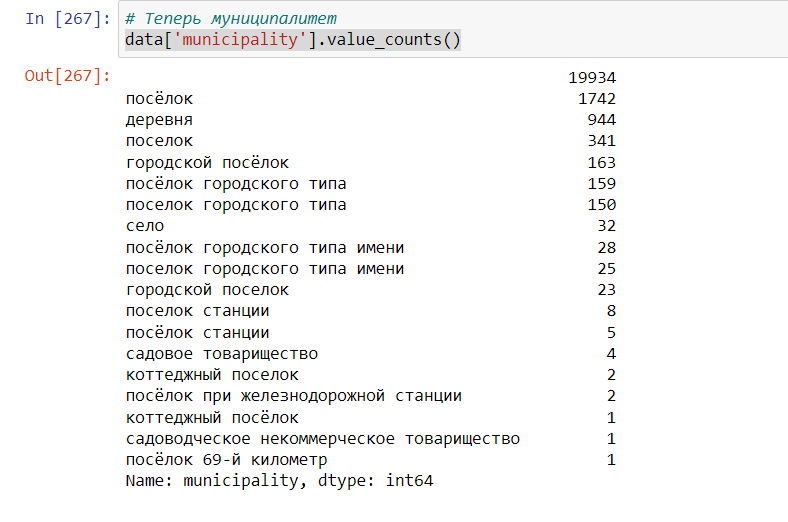

In [56]:
# Название поселения определим по наличию большой буквы
for i in data.index:
    for j in data.loc[i, 'locality_name_list']:
        if j.islower() == True:
            if j in ['поселок', 'село']:
                data.loc[i, 'municipality'] = data.loc[i, 'municipality'] + 'посёлок '
            elif j in ['имени']:
                data.loc[i, 'name'] = data.loc[i, 'name'] + 'ПГТ имени '
            else:         
                data.loc[i, 'municipality'] = data.loc[i, 'municipality'] + j + ' '
        if j.islower() == False:
            data.loc[i, 'name'] = data.loc[i, 'name'] + j + ' '   

In [57]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition,locality_name_list,name,municipality
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,False,False,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,[Санкт-Петербург],Санкт-Петербург,
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.75,11.0,18.6,1,False,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,"[посёлок, Шушары]",Шушары,посёлок
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.55,5.0,34.3,4,False,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,[Санкт-Петербург],Санкт-Петербург,
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.63,14.0,45.1,9,False,False,False,10.65,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,[Санкт-Петербург],Санкт-Петербург,
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,False,False,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,[Санкт-Петербург],Санкт-Петербург,


In [58]:
# Посмотрим, что там со значениями
data['name'].value_counts()

Санкт-Петербург           15651
Мурино                      586
Кудрово                     470
Шушары                      439
Всеволожск                  398
Пушкин                      369
Колпино                     338
Парголово                   327
Гатчина                     307
Выборг                      237
Петергоф                    201
Сестрорецк                  183
Красное Село                176
Новое Девяткино             143
Сертолово                   142
Ломоносов                   133
Кириши                      125
Бугры                       113
Сланцы                      112
Волхов                      111
Тосно                       104
Кингисепп                   104
Кронштадт                    96
Никольское                   94
Коммунар                     89
Сосновый Бор                 87
Кировск                      84
Отрадное                     80
Янино-1                      68
Металлострой                 66
Приозерск                    66
Старая  

In [59]:
# Теперь муниципалитет
data['municipality'].value_counts()

                                              19934
посёлок                                        2115
деревня                                         944
посёлок городского типа                         362
городской посёлок                               186
посёлок станции                                  13
садовое товарищество                              4
коттеджный посёлок                                3
посёлок при железнодорожной станции               2
садоводческое некоммерческое товарищество         1
посёлок 69-й километр                             1
Name: municipality, dtype: int64

Осталось привести в порядок СНТ, ПГТ и оставшиеся посёлки, решим проблему вручную:

In [60]:
# Забьём список уникальными названиями и заменим их обычным посёлком
bad_naming_list = ['посёлок станции ', 'коттеджный посёлок ', 'посёлок при железнодорожной станции ', 'посёлок 69-й километр ']

for i in data.index:
    if data.loc[i, 'municipality'] in bad_naming_list:
        data.loc[i, 'municipality'] = 'посёлок '

In [61]:
data['municipality'].value_counts()

                                              19934
посёлок                                        2134
деревня                                         944
посёлок городского типа                         362
городской посёлок                               186
садовое товарищество                              4
садоводческое некоммерческое товарищество         1
Name: municipality, dtype: int64

То же самое для ПГТ и СНТ

In [62]:
data.loc[data['municipality'] == 'городской посёлок ', 'municipality'] = 'посёлок '
data.loc[data['municipality'] == 'садовое товарищество ', 'municipality'] = 'СНТ '
data.loc[data['municipality'] == 'садоводческое некоммерческое товарищество ', 'municipality'] = 'СНТ '

In [63]:
data['municipality'].value_counts()

                            19934
посёлок                      2320
деревня                       944
посёлок городского типа       362
СНТ                             5
Name: municipality, dtype: int64

Profit!
Только удалим пробелы в конце строк.


In [64]:
data['municipality'] = data['municipality'].str.strip()
data['name'] = data['name'].str.strip()

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  object 
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

### Восполняем оставшиеся значения

In [66]:
# Глянем, что там по медианам оставшихся столбцов
maps_data = data.pivot_table(index='name', values=['airports_nearest', 'city_centers_nearest',
                                                   'parks_around', 'parks_nearest', 'ponds_around',
                                                   'ponds_nearest'], aggfunc=['mean'])
maps_data.columns = ['airports_nearest', 'city_centers_nearest', 'parks_around',
                    'parks_nearest', 'ponds_around', 'ponds_nearest']
maps_data

,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest
name,,,,,,
Александровская,12896.500000,27468.000000,0.000000,NaN,1.000000,711.500000
Белоостров,57769.000000,38868.000000,0.000000,NaN,1.000000,320.000000
Зеленогорск,73300.250000,54617.583333,1.916667,210.625000,0.875000,485.888889
Колпино,26375.863501,32113.771513,0.522255,495.481203,0.997033,532.268421
Красное Село,26610.028736,30034.741379,0.482759,468.400000,0.091954,445.500000
Кронштадт,67469.263158,49195.726316,1.789474,324.574713,1.936842,343.413793
Левашово,52693.000000,25727.000000,0.000000,NaN,0.000000,NaN
Лисий Нос,55302.333333,27613.333333,0.000000,NaN,0.000000,NaN
Ломоносов,48308.280303,50739.969697,0.242424,389.062500,1.128788,550.048193


В данном случае, многие объекты обладают схожими параметрами. Запосление значений медипной не повлечет сильного искажения данных. На этот раз критерий - населенный пункт.

In [67]:
# Та же функция, что и раньше, но по критерию населенного пункта
for i in data.loc[:, 'airports_nearest':'ponds_nearest'].columns:
    for j in maps_data.index:
        data.loc[(data[i].isna()) & (data['name'] == j), i] = maps_data.loc[j, i]

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  object 
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

In [69]:
# Сделаем вывод, что там где не удалось достать информацию о близости парка или водоёма, ничего рядом нет
data['parks_around'] = data['parks_around'].fillna(0)
data['ponds_around'] = data['ponds_around'].fillna(0)
print(data['parks_around'].isna().sum(), data['ponds_around'].isna().sum())

0 0


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  object 
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Большую часть пропусков удалось устранить, будем считать этот результат приемлемым для дальнейшего анализа.

### Перед переходом к дальнейшему исследованию, доведем до ума типы данных столбцов

Переводу в int подлежат столбцы: floors_total, balcony, parks_around, ponds_around. Дробные значения в этих столбцах - нелогичны. У нас нет поблизости 1,5 парка или квартир расположенных на 2,4 этаже.

In [72]:
# переведем их в int
#for i in ['floors_total', 'balcony', 'parks_around', 'ponds_around', 'days_exposition']:
data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['parks_around'] = data['parks_around'].astype('int')
data['ponds_around'] = data['ponds_around'].astype('int')

Заодно переведем день размещения в формат даты, чтобы иметь возможность дальше работать с этим столбцом.

In [73]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [75]:
data['last_price'] = data['last_price'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  int32         
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int32         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  object        
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

## Добываем новые данные

Время добавить следующие столбцы
- цена одного квадратного метра;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «‎первый», «последний», «другой»);
- расстояние до центра города в километрах

### ***Цена одного квадратного метра***

In [83]:
data['square_meter_price'] = data['last_price'] / data['total_area'] 

In [84]:
data['square_meter_price'] = data['square_meter_price'].astype('int')

In [85]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition,locality_name_list,name,municipality,square_meter_price,exposition_weekday,exposition_month,exposition_year
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.000000,NaN,[Санкт-Петербург],Санкт-Петербург,,120370,3,3,2019
1,7,3350000,40.4,2018-12-04,1,2.75,11,18.6,1,False,False,False,11.00,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,573.217105,81.0,"[посёлок, Шушары]",Шушары,посёлок,82920,1,12,2018
2,10,5196000,56.0,2015-08-20,2,2.55,5,34.3,4,False,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.000000,558.0,[Санкт-Петербург],Санкт-Петербург,,92785,3,8,2015
3,0,64900000,159.0,2015-07-24,3,2.63,14,45.1,9,False,False,False,10.65,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.000000,424.0,[Санкт-Петербург],Санкт-Петербург,,408176,4,7,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.000000,121.0,[Санкт-Петербург],Санкт-Петербург,,100000,1,6,2018


###  ***День недели публикации объявления***

In [79]:
data['exposition_weekday'] = data['first_day_exposition'].dt.weekday

<Axes: >

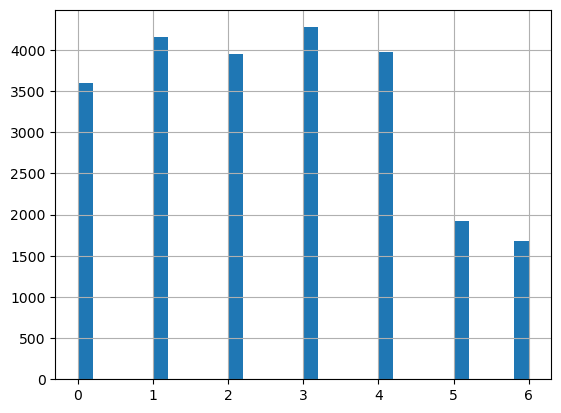

In [80]:
data['exposition_weekday'].hist(bins=30)

Попутно можно сделать вывод, что пик публикаций приходится на четверг и вторник

### ***Месяц публикации объявления***

In [81]:
# Подобрым образом создадим столбцы с месяцем и годом публикации
data['exposition_month'] = data['first_day_exposition'].dt.month
data['exposition_year'] = data['first_day_exposition'].dt.year

<Axes: >

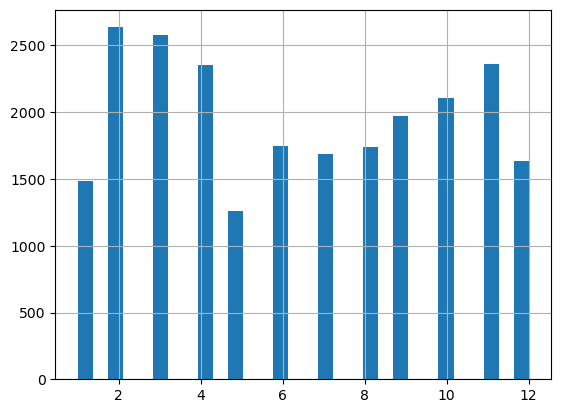

In [82]:
data['exposition_month'].hist(bins=30)

Наглядная тенденция, что предложение падает в летний период.

### ***Год публикации объявления***

<Axes: >

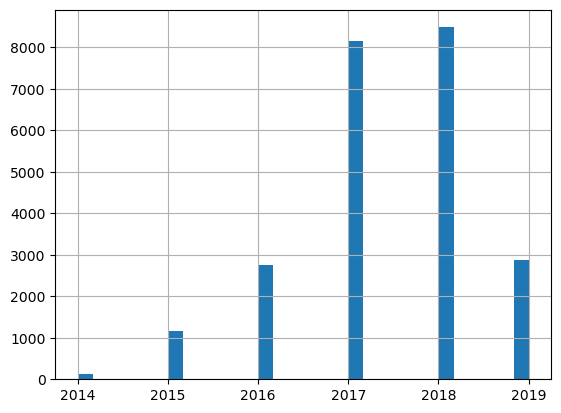

In [86]:
data['exposition_year'].hist(bins=30)

Скорее всего сервис начал работать в 2014 году и к 2018 нарастил количество пользователей, а база с которой мы работаем выгружена, скоре всего, в 2019 году, поэтому наблюдается резкое падение предложения.

### ***Тип этажа квартиры***

Создадим столбец содержащий тип этажа квартиры

In [87]:
# Создадим копию столбца floor и заменим значения на требуемые
data['floor_type'] = data['floor']

data.loc[data['floor_type'] == 1, 'floor_type'] = 'первый'
data.loc[data['floor_type'] == data['floors_total'], 'floor_type'] = 'последний'
data.loc[(data['floor_type'] != 'первый') & (data['floor_type'] != 'последний'), 'floor_type'] = 'другой'

### ***Расстояние до центра города в километрах***

Также посчитаем расстояние до центра в километрах, пропущенные значения будем игнорировать

In [89]:
# Преобразуем все непустые значения
data['city_centers_km'] = data['city_centers_nearest'] / 1000
data.loc[~data['city_centers_km'].isna(), 'city_centers_km'] = data.loc[~data['city_centers_km'].isna(),
                                                                        'city_centers_km'].astype('int')

data['city_centers_km'] = data['city_centers_km'].astype('Int64')
#data.round({'city_centers_km': 0})
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition,locality_name_list,name,municipality,square_meter_price,exposition_weekday,exposition_month,exposition_year,floor_type,city_centers_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.000000,NaN,[Санкт-Петербург],Санкт-Петербург,,120370,3,3,2019,другой,16
1,7,3350000,40.4,2018-12-04,1,2.75,11,18.6,1,False,False,False,11.00,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,573.217105,81.0,"[посёлок, Шушары]",Шушары,посёлок,82920,1,12,2018,первый,18
2,10,5196000,56.0,2015-08-20,2,2.55,5,34.3,4,False,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.000000,558.0,[Санкт-Петербург],Санкт-Петербург,,92785,3,8,2015,другой,13
3,0,64900000,159.0,2015-07-24,3,2.63,14,45.1,9,False,False,False,10.65,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.000000,424.0,[Санкт-Петербург],Санкт-Петербург,,408176,4,7,2015,другой,6
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.000000,121.0,[Санкт-Петербург],Санкт-Петербург,,100000,1,6,2018,другой,8


Норм, можем двигаться дальше.

### Время сследовательского анализа данных

### Исследования гистограмм отдельных параметров

<Axes: >

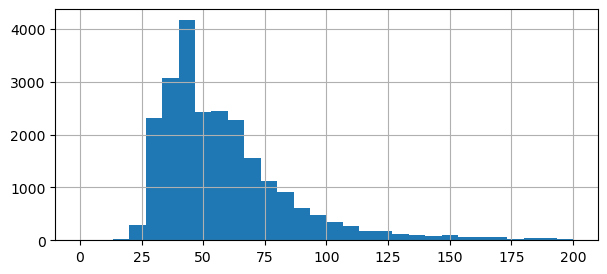

In [91]:
# Общая площадь
data['total_area'].hist(figsize=(7, 3), bins=30, range=(0,200), grid=True)

Исходя из увиденного, можно утверждать, что на рынке преобладают предложения от 25 до 50 м2, при этом с увеличением площади, уменьшается и количество предложений, что является нормальным распределением.

<Axes: >

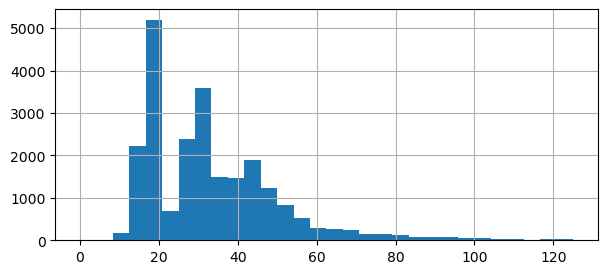

In [93]:
# Жилая площадь
data['living_area'].hist(figsize=(7, 3), bins=30, range=(0,125), grid=True)

Учитывая размер жилой площади, можно сказать, что преобладают малогабаритные квартиры.

<Axes: >

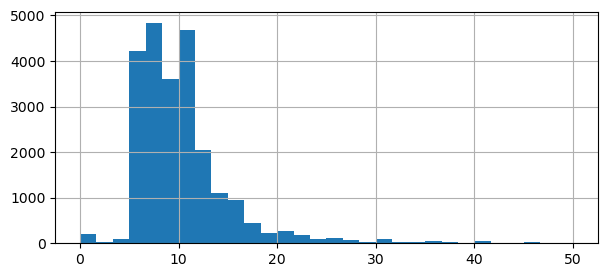

In [94]:
# Площадь кухни
display(data['kitchen_area'].hist(figsize=(7, 3), bins=30, range=(0,50)))

Преобладают вполне стандартные кухни, нтакже имеется интересный всплеск в районе около 12 м2.

<Axes: >

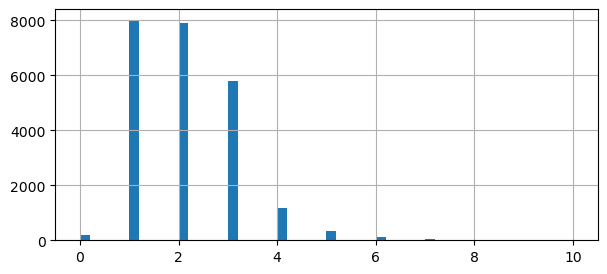

In [95]:
# Количество комнат
display(data['rooms'].hist(figsize=(7, 3), bins=50, range=(0,10)))

Результат отлично соотносится с предыдущими схемами, на рынке преобладают 1 и 2-комнатные квартиры, с относительно небольшими кухнями.

<Axes: >

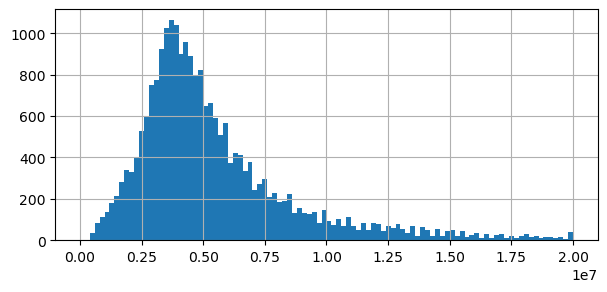

In [96]:
# Цена объекта
data['last_price'].hist(figsize=(7, 3), bins=100, range=(0,20000000))

Наблюдается нормальное распределение Пуассона, наибольшее количество объявлений находится в промежутке от 2,5 до 5 млн. рублей. Примерно столько и стоят двушки/однушки

<Axes: >

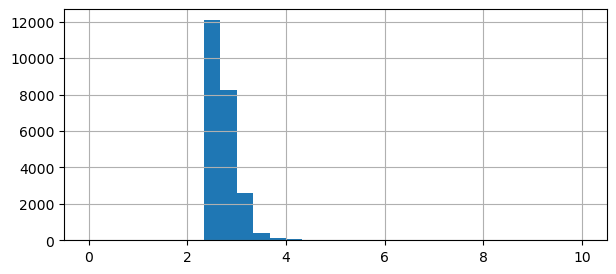

In [97]:
display(data['ceiling_height'].hist(figsize=(7, 3), bins=30, range=(0,10)))

Чуть больше двух метров, стандарт, хотя встречаются уникальные дома с потолками от 3 метров.

<Axes: >

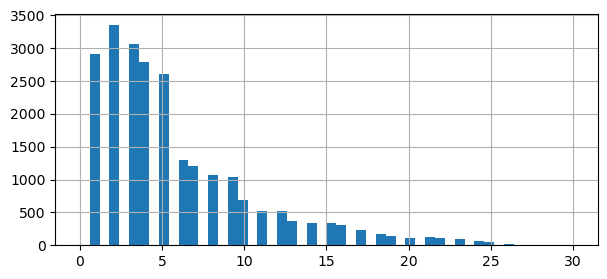

In [98]:
# Этаж выставляемой квартиры
display(data['floor'].hist(figsize=(7, 3), bins=50, range=(0,30)))

In [99]:
data.pivot_table(index='floor', values='last_price', aggfunc=('count')).sort_values('last_price', ascending=False)

,last_price
floor,
2,3351
3,3061
1,2909
4,2793
5,2612
6,1293
7,1211
8,1075
9,1045


Чаще всего продают нижние этажи, посторим гисторгамму по показателю общей этажности.

<Axes: >

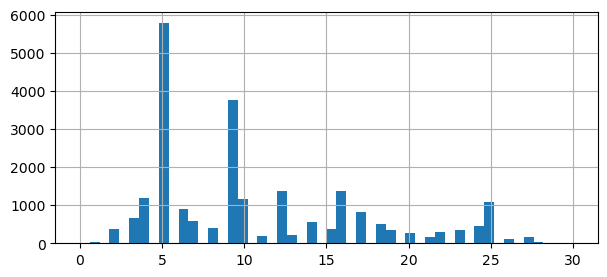

In [101]:
# Всего этажей
display(data['floors_total'].hist(figsize=(7, 3), bins=50, range=(0,30)))

Вот и ответ, в Ленинградской области преобладают пятиэтажные дома, отсюда и количество объявлений о продаже квартир на 1-5 этаже.

<Axes: >

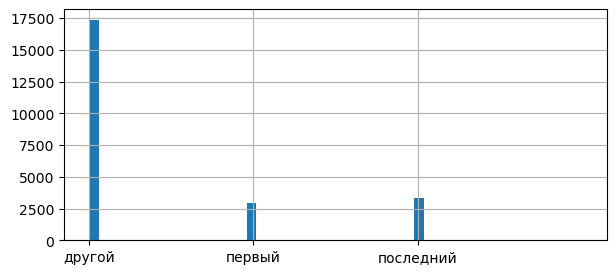

In [102]:
# Тип этажа квартиры
data['floor_type'].hist(figsize=(7, 3), bins=50, range=(0,3))

Почти треть всех объявлений представлены первым и последним этажом, возможно шраждане испытывают дискомфорт при проживании там.

<Axes: >

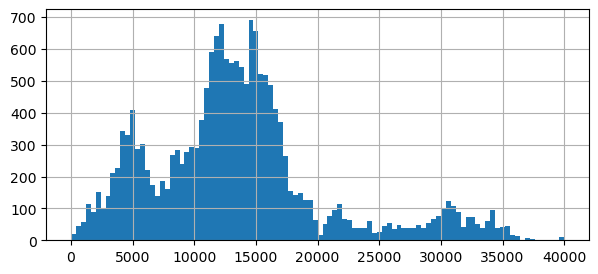

In [103]:
# Расстояние до центра города в метрах
data['city_centers_nearest'].hist(figsize=(7, 3), bins=100, range=(0, 40000))

Наибольшее предложение - 10-17 км от центра, но в радиусе 5 км, наблюдается небольшой всплеск объявлений. Возможно это связано с  транспортными развязкамиб метро и т.п.

<Axes: >

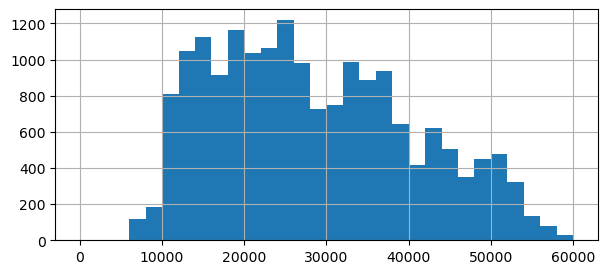

In [104]:
# Расстояние до ближайшего аэропорта
data['airports_nearest'].hist(figsize=(7, 3), bins=30, range=(0, 60000))

Расстояние до ближайшего аэропорта очень сильно варьируется, но ближе 10 км почти нет объявлений.

<Axes: >

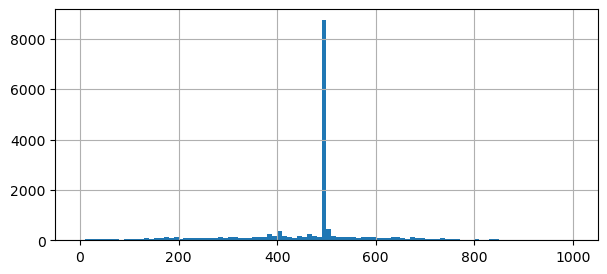

In [105]:
# Расстояние до ближайшего парка
data['parks_nearest'].hist(figsize=(7, 3), bins=100, range=(0, 1000))

В среднем, для ленинградской области характерен показатель 500 м до парка, но это может быть связано с тем, что мы заполнили пропуски медианами по городу.

<Axes: xlabel='exposition_year,exposition_month'>

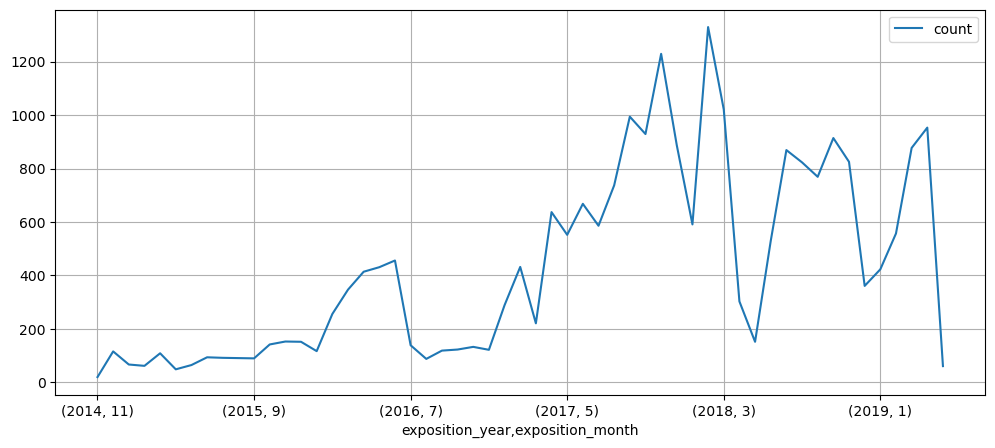

In [106]:
# Рассмотрим год/месяц объявления
exposition_month = data.pivot_table(index=['exposition_year', 'exposition_month'], values='locality_name',
                 aggfunc=['count'])

exposition_month.columns = ['count']

exposition_month.plot(y='count', grid=True, figsize=(12,5))    


С развитием сервиса, количество объявлений рослоб однако встречаются резкие падения активности в марте 2018 и январе 2019, также сводная таблица подтвердила гипотезу, что 2019-й год выгружен не полностью.

**Рассмотрим отдельно день недели / месяц года?**

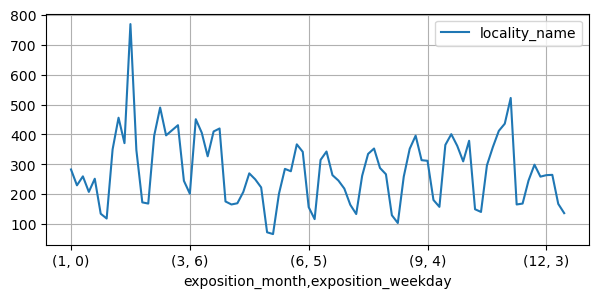

In [108]:
# Рассмотрим потдельно показатели месяц/неделя

exposition_month = data.pivot_table(index=['exposition_month', 'exposition_weekday'], values='locality_name',
                 aggfunc=['count'])

exposition_month['index'] = exposition_month.index.to_list()
exposition_month.plot(y='count', grid=True, figsize=(7, 3))
plt.show()

На графике видна динамика активности, к выходным она падает, а по будням возрастает, но хотелось бы отобразить промежуточные значения оси Х, в интернетах не нашел доступного объяснения как это сделать. То есть нужно как-то особразить на больших делениях месяцы, а между ними недели.

### Изучим, как быстро продавались квартиры

In [109]:
data.agg({'days_exposition' : ['mean', 'median']})

,days_exposition
mean,180.741395
median,95.000000


<Axes: >

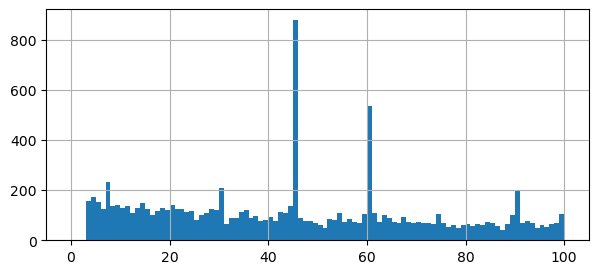

In [111]:
data['days_exposition'].hist(figsize=(7, 3), bins=100, range=(0,100))

Выходит, что пики закрытия объявлений приходятся на 45 и 60 дней, это может быть связано как с продажей, так и со снятием объявления для его повторного размещения, чтобы оно снова появилось в топе.

<Axes: >

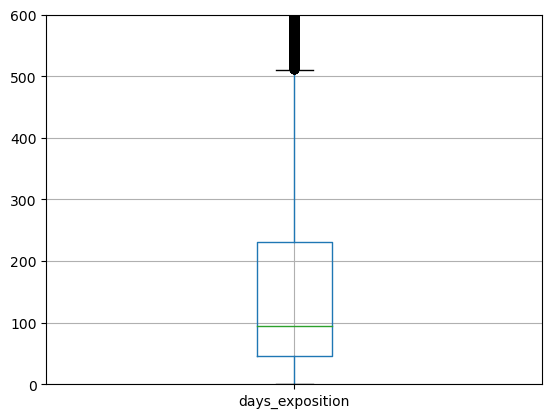

In [112]:
# Заодно построим диаграмму размаха
plt.ylim(0, 600)
data.boxplot(column='days_exposition')

In [113]:
print(data['days_exposition'].describe())

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64


На гистограмме видно, что среди объявлений имеются те, котороые продаются необычайно долго. Из-за этого мы наблюдаем искажение среднего значения в большую сторону, которое сильно отличается от медианы, 120 против 95 дней. Приэтом, смотряна диаграмму размаха, можно сказать, что в среднем, быстрой можно считать продажу произведенную в течение 45 дней. Долгой можно считать продажу свыше 231 дня. Аномально долгими свыше 500 дней.

### Изучим, какие факторы больше всего влияют на общую (полную) стоимость объекта

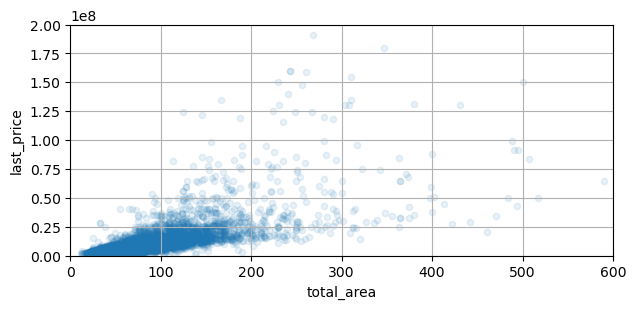

In [116]:
data.plot(x='total_area', y='last_price', kind='scatter', grid=True, figsize=(7, 3),
         xlim=(0, 600), ylim=(0, 200000000), alpha=0.1)
plt.show()

In [117]:
# Найдем коэффициент корреляции Пирсона
print(data['total_area'].corr(data['last_price']))

0.6536213939252805


Текущий показатель корреляции говорит существовании взаимосвязи, не слишком сильной.

In [118]:
# В задании нет такого но интересно посмотреть зависимость от близости к центру.
#data.pivot_table(index='city_centers_nearest', values='last_price',
#                 aggfunc=('median')).plot(y='last_price', grid=True, figsize=(12,5)) 

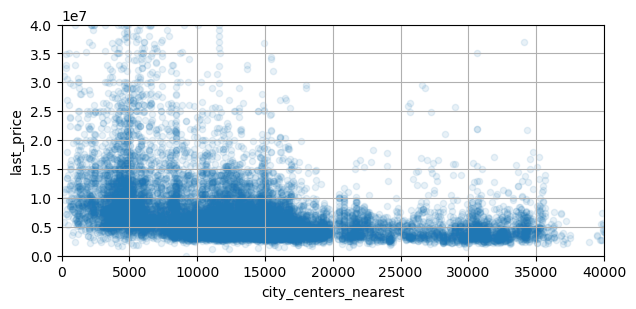

In [119]:
data.plot(x='city_centers_nearest', y='last_price', kind='scatter', grid=True, figsize=(7, 3), alpha=0.1,
         xlim=(0, 40000), ylim=(0, 40000000))
plt.show()

In [120]:
# Найдем коэффициент корреляции Пирсона
print(data['city_centers_nearest'].corr(data['last_price']))

-0.20592392302596613


Можно сделать вывод, что с уменьшением расстояния до центра, увеличивается стоимость предложения, но более влиятельным фктором остаётся площадь квартиры.

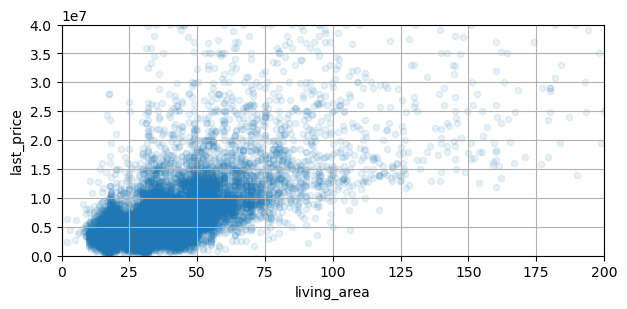

In [123]:
data.plot(x='living_area', y='last_price', kind='scatter', grid=True, figsize=(7, 3), alpha=0.1,
         xlim=(0, 200), ylim=(0, 40000000))
plt.show()

In [124]:
# Найдем коэффициент корреляции Пирсона
print(data['living_area'].corr(data['last_price']))

0.5579299508884674


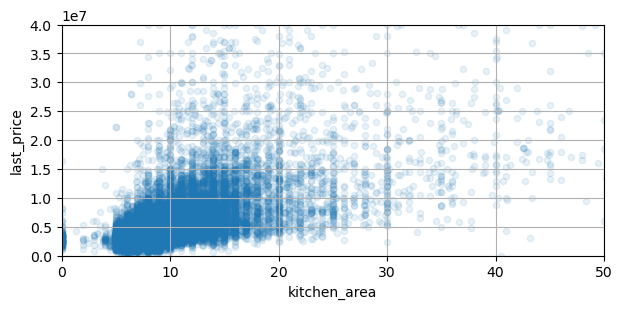

In [126]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', grid=True, figsize=(7, 3), alpha=0.1,
         xlim=(0, 50), ylim=(0, 40000000))
plt.show()

In [127]:
# Найдем коэффициент корреляции Пирсона
print(data['kitchen_area'].corr(data['last_price']))

0.45397886973128543


Касательно влияния жилой площади и площади и жилой площади, влияют на цену они скорее механически, чем больше квадратных метров, там больше цена, щилая площадь имеет чуть большую взаимосвязь с ценой, чем площадь кухни.

<Axes: xlabel='rooms'>

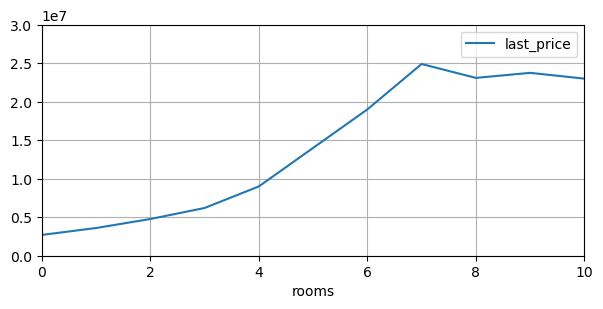

In [129]:
# Зависимость цены от количества комнат
data.pivot_table(index='rooms', values='last_price',
                 aggfunc=('median')).plot(y='last_price', grid=True, figsize=(7, 3), xlim=(0, 10), ylim=(0, 30000000))

Наблюдается прямая зависимость между стоимостью квартиры и количеством комнат, хоть это и не единственный фактор, влияющий на стоимость.

<Axes: xlabel='floor'>

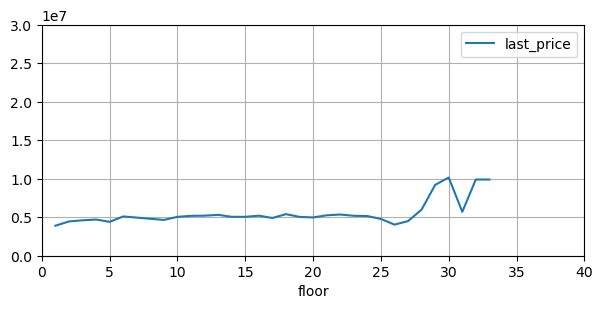

In [130]:
# Зависимость цены от количества комнат
data.pivot_table(index='floor', values='last_price',
                 aggfunc=('median')).plot(y='last_price', grid=True, figsize=(7, 3), xlim=(0, 40), ylim=(0, 30000000))

Этаж почти не влияет на стоимость квартиры, первые этажи чуть дешевле, хотя наблюдается всплеск на вершинах высотных зданий, но это очень редкие предложения.

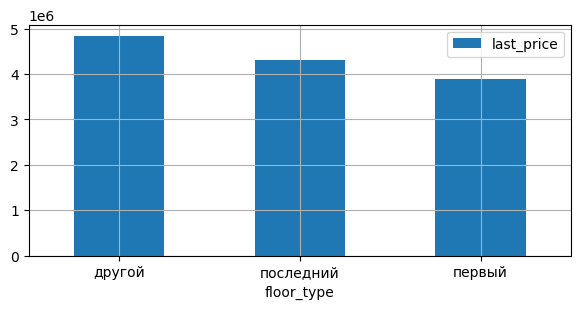

In [138]:
(
data.pivot_table(index='floor_type', values='last_price', aggfunc=('median'))
    .sort_values('last_price', ascending=False).head(10)
    .plot(grid=True, figsize=(7, 3), kind='bar')
)
plt.xticks(rotation = 0)
plt.show()

В результате, первый и последний этаж действительно дешевле аналогов на других этажах. Причем последний предпочтительнее первого

Традиционно, квартиры на первом и последнем этажах считаются самыми неудобными для жизни и это отражается на их стоимости.

### Изучим динамику предложений по дням недели, месяцам и годам

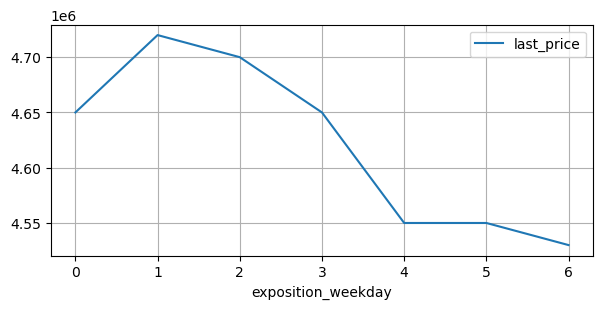

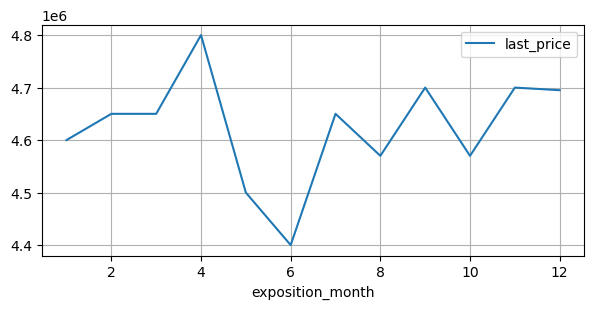

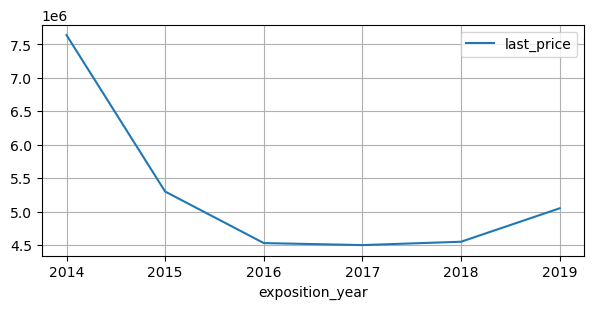

In [141]:
# для этого воспользуемся циклом
for i in data.loc[:, 'exposition_weekday':'exposition_year']:
    plt.show(data.pivot_table(index=i, values='last_price',
                     aggfunc=('median')).plot(y='last_price', grid=True, figsize=(7, 3)))

В дополнение к предыдущей диаграмме, посмотрим взаимосвязь года публикации объявления и среднего количества комнат.

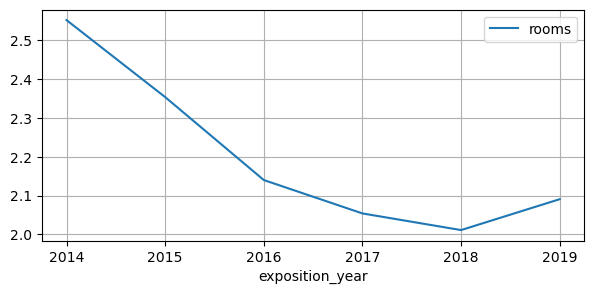

In [143]:
# В дополнение к пред
plt.show(data.pivot_table(index='exposition_year', values='rooms',
                     aggfunc=('mean')).plot(y='rooms', grid=True, figsize=(7, 3)))

Можно наблюдать прямую взаимосвязь между вумя графиками, что говорит о том, что со временем выросло предложение малогабаритного жилья, от чего мы наблюдаем снижение показателя медианной стоимости объявления.

На основании представленных диаграмм можно сделать следующие выводы:
- Наиболее крупные предложения выставляются в будние дни;
- В летний период происходит снижение динамики продаж;
- За пятилетний период выросло предложение на малогабаритное недорогое жильё.

### ***Выделим 10 населенных пунктов с самой большой стоимостью квадратного метра***

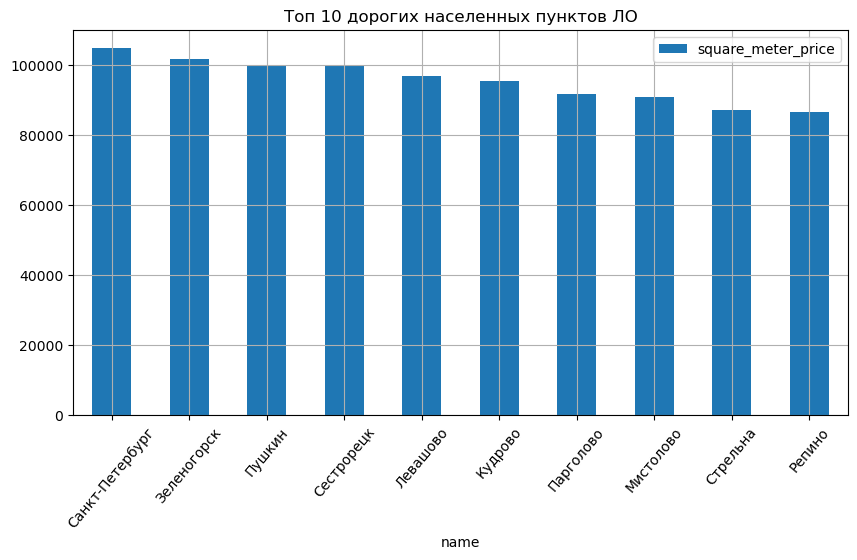

In [166]:
(
data.pivot_table(index='name', values='square_meter_price', aggfunc=('median'))
    .sort_values('square_meter_price', ascending=False).head(10)
    .plot(grid=True, figsize=(10, 5), kind='bar')
    )
plt.xticks(rotation=50)
plt.title('Топ 10 дорогих населенных пунктов ЛО')
plt.show()

Как и ожидалось, лидером по стоимости квадратного метра выступает Санкт-Петербург, далее ближайшие пригороды.
Тройку лидеров составляют: 
- СПБ - 104774 за м2;
- Зеленогорск - 101666 за м2;
- Пушкин - 100000 за м2.

In [158]:
data.pivot_table(index='name', values='square_meter_price', aggfunc=('median')).sort_values('square_meter_price', ascending=False).head(10)

,square_meter_price
name,
Санкт-Петербург,104774.0
Зеленогорск,101666.5
Пушкин,100000.0
Сестрорецк,99678.0
Левашово,96997.0
Кудрово,95555.0
Парголово,91642.0
Мистолово,90888.0
Стрельна,87254.0


Посмотрим конец нашего топа:

<Axes: xlabel='name'>

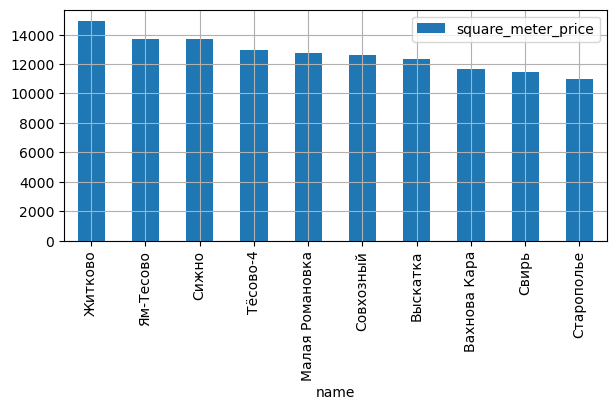

In [160]:
(
data.pivot_table(index='name', values='square_meter_price', aggfunc=('median'))
    .sort_values('square_meter_price', ascending=False).tail(10)
    .plot(grid=True, figsize=(7, 3), kind='bar')
)

Тройку лидеров с конца занимают:
- Деревня Вахнова Кара - 11688 за м2;
- Поселок Свирь - 11481 за м2;
- Деревня Старополье - 11000 за М2;

In [161]:
data.pivot_table(index='name', values='square_meter_price', aggfunc=('median')).sort_values('square_meter_price', ascending=False).tail(10)

,square_meter_price
name,
Житково,14956.0
Ям-Тесово,13711.0
Сижно,13709.0
Тёсово-4,12931.0
Малая Романовка,12724.0
Совхозный,12628.5
Выскатка,12335.0
Вахнова Кара,11688.0
Свирь,11481.0


### ***Опишем, как стоимость объектов зависит от расстояния до центра города***

В расчете будем использовать стоимость квадратного метра, так мы снизим влияние размеров отдельных квартир на график.

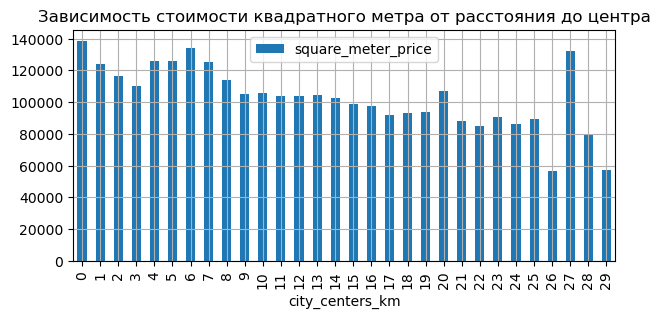

In [164]:
(
data[data['name'] == 'Санкт-Петербург']
    .pivot_table(index='city_centers_km', values='square_meter_price', aggfunc=('median'))
    .plot(grid=True, figsize=(7,3), kind='bar', title = 'Зависимость стоимости квадратного метра от расстояния до центра')
);

В районе центра наблюдается рекордная стоимость квадратного метра в размере 138 536 рублей.
Ниже 100 000 стоимость падает в радиусе 15 км. По городу изменение цены не сильно радикальное, резкое падение наблюдается на 26-м километре. Но на 27-м виден аномальный всплеск.

In [165]:
data[(data['name'] == 'Санкт-Петербург') & (data['city_centers_km'] == 27)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around,parks_nearest,ponds_around,ponds_nearest,days_exposition,locality_name_list,name,municipality,square_meter_price,exposition_weekday,exposition_month,exposition_year,floor_type,city_centers_km
748,13,14350000,74.0,2017-11-28,2,3.13,5,30.0,3,False,False,False,25.0,0,Санкт-Петербург,23888.0,27313.0,1,1496.000000,0,520.391129,128.0,[Санкт-Петербург],Санкт-Петербург,,193918,1,11,2017,другой,27
5961,6,2250000,32.0,2018-02-27,1,2.60,2,16.5,2,False,False,False,7.0,0,Санкт-Петербург,24006.0,27431.0,0,498.338298,0,520.391129,178.0,[Санкт-Петербург],Санкт-Петербург,,70312,1,2,2018,последний,27


Взглянув на объявления в радиусе 27 км. Мы видим, что всплеск обусловлен завышенной стоимостью оконкретного предложения.

### Общий вывод

Данное исследование проводилось с целью построения автоматизированной системы по отслеживанию аномалий и мошеннических действий, а также найти интересные особенности и зависимости. 

**Работа проводилась в несколько этапов, которые включали в себя:**
- Изучение данных;
- Предобработку данных;
- Исследовательский анализ данных.

**Анализ плказал что наибольшее количество пропусков наблюдается в столбцах:**
- is_apartment - 80%;
- parks_nearest - 65%;
- ponds_nearest - 61%;
- balcony - 48%.

Наибольшую обеспокоенность вызывают именно пропуски в информации об апартаментах. Учитывая тот факт, что апартаменты имеют несколько отличный правовой статус, то утаивание информации о том, что это апартаменты, может свидетельствовать о возможных мошеннических действиях, как минимум по продаже апартаментов под видом жилого помещения. Также из-за низкой стоимости апартаметнов, их могут размещать без указания этого статуса для привлечения внимания к объявлению, чаще всего это происходит среди аккаунтов агентств недвижимости. В связи с чем рекомендую сделать эту графу оязательной для заполнения без возможности разместить объявление без этой информации.

Пропущенные показатели в столбцах parks_nearest, ponds_nearest говорят о несовершенстве автоматической системы по определению катрографических данных, однако эти данные можно исключить из исследования, т.к. наличие парка или водоёма не оказывает существенного врияния на стоимость.

Рекомендация: Сделать заполнение всех полей обязательным для пользователя, без возможности разместить оъявление без данных. Также стоит установить ограничить максимальную высоту потолков при вводе во избежание таких значений как 18 или 25 м. Можно поставить лимит на 10 м. Возможно стоит создать базу данных, которая будет содержать в себе тип и параметры дома на основании информации из открытых источников.

**В ходе исследования было выдинуто несколько гипотез:**
1. Наибольшее предложение имеется среди малогабаритных квартир 1-2 комнаты.
2. В данных имеются аномалии, например, всплески на графике количества этажей. Это может быть связано с типовой застройкой зданиями 5 и 9 этажей.
3. Продать чаще всего пытаются квартиры на нижних этажах.
4. Большинство предложений закрываются за первые 250 дней публикации

**Гипотеза 1 - подтверждена.**
В результате построения гистограммы по данным сводной таблицы, на рынке преобладают 1 и 2-комнатные квартиры, с относительно небольшими кухнями. 8004 объявления - однокомнатные, 7897 объявлений - двухкомнатные.
По стоимости наблюдается нормальное распределение Пуассона, наибольшее количество объявлений находится в промежутке от 2,5 до 5 млн. рублей, данная стоимость как раз приходится на диапазон 1 и 2 комнатных квартир.

**Гипотеза 2 - подтверждена.**
Наиболее распространенные типы домов в Ленинградской области 5 и 9-ти этажные здания. Что подтверждается гистограммой.
Тройку лидеров составляют:
- 5	- 5775 объявлений.
- 9	- 3758 объявлений.
- 16- 1375 объявлений.

**Гипотеза 3 - подтверждена частично.**
В Ленинградской области преобладают объвления о продаже квартир в пятиэтажных домах, что отражается на статистики продаж нижних этажей. Также оказалось, что активнее продается не первый этаж, а второй и третий.
По цифрам результат следующий:
- 2-й этаж	- 3351 объявлений.
- 3-й этаж	- 3061 объявлений.
- 1-й этаж	- 2909 объявлений.

**Гипотеза 4 - подтверждена.**
В результате исследования бало выявлено, что среднее значение продажи квартиры составляет 95 дней. 250 находится за пределами третьего квартиля, это говорит на м о том, что в рамках данной площадки 250 дней продажи считается долгим сроком.

Помимо проверки гипотез был составлен топ самых дорогих и бюджетных населенных пунктов в Ленинградской области:

Тройку лидеров составляют:

- СПБ - 104774 за м2;
- Зеленогорск - 101666 за м2;
- Пушкин - 100000 за м2.

Тройка лидеров с конца:

- Деревня Вахнова Кара - 11688 за м2;
- Поселок Свирь - 11481 за м2;
- Деревня Старополье - 11000 за М2;

Также были сделаны промежуточные выводы о влиянии на стоимость жилья таких факторов как площадь кваритры, жилая площадь, площадь кухни, удаленность о центра.

Коэффициент корреляции Пирсона показал:
- больше всего стоимость квартиры зависит от площади - коэфф. 0.65;
- чем ближе к центру тем выше цена, но это не самый влиятельный критерий - коэфф. -0.20;
- жилая площадь взаимосвязана с ценой чуть меньше, чем общая площадь, но тоже весомый фактор - коэфф. 0.55;
- площадь кухни не самый важный показатель при формировании стоимости - коэфф. 0.45

Поэтому, площадь квартиры - приоритетный показатель при формировании стоимости предложения.

Возвращаясь к цели исследования можно утверждать, что для работы алгоритма выявления потнциальных мошеннических схем следует ограничить пользователя в возможности пропускать отдельные графы при заполнении информации об объявлении, а также стоит уделить особое внимание объявлениям значительно отколоняющимся от медианного значения стоимости квадратного метра с учетом удаления недвижимости от центра города.

Спасибо за внимание!